### Goal
Implement the gene_effect + individual_effect using a keras model.evaluation

In [2]:
import seaborn as sns
import comet_ml
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.externals import joblib
import sklearn as sk
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LassoLarsCV, LinearRegression, RidgeCV, SGDRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA, KernelPCA, IncrementalPCA
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import spearmanr, pearsonr
import rep.preprocessing_new as prep
import rep.datasets as d
import rep.models as m
import warnings; warnings.simplefilter('ignore')

np.random.seed(1)

from keras.layers import Input, Dense, Add
from keras.models import Model
from keras.optimizers import Adam

from scipy.stats import spearmanr, pearsonr


import matplotlib.pyplot as plt
%matplotlib inline

### 1. Build linear model with PCA (per genes and per samples) model


In [3]:
# load train valida data
path = "/s/project/rep/"
# path = "/home/mada/Uni/Masterthesis/online_repo/rep/data/"
y_targets_h5 = path + "processed/gtex/input_data/Y_targets_pc_onlyblood.h5"
x_inputs_h5 =  path + "processed/gtex/input_data/X_inputs_pc_onlyblood.h5"
train_dataset, valid_dataset = d.rep_blood_expression(x_inputs_h5, y_targets_h5, label=None)

metadata_samples_train, metadata_samples_valid = train_dataset.metadata, valid_dataset.metadata
features_train, features_valid = train_dataset.features, valid_dataset.features
x_train, y_train = train_dataset.inputs, train_dataset.targets
x_valid, y_valid = valid_dataset.inputs, valid_dataset.targets

# load gtex data
features_file = path + "processed/gtex/recount/recount_gtex_logratios.h5ad"
train_individuals_file = path + "processed/gtex/recount/train_individuals.txt"
train_individuals = prep.read_csv_one_column(train_individuals_file)

valid_individuals_file = path + "processed/gtex/recount/valid_individuals.txt"
valid_individuals = prep.read_csv_one_column(valid_individuals_file)

gtex = prep.RepAnnData.read_h5ad(features_file)
gtex_filtered = gtex[gtex.samples['Individual'].isin(train_individuals + valid_individuals)]
gtex_filtered_train = gtex[gtex.samples['Individual'].isin(train_individuals)]
del gtex


### 1.1. Compute $P$ = PCA individual effect (all individuals in train and valid in blood)
   - input $X$: dim($X$) = #indiv x #genes (only blood)<br/>
   - output $P$: dim($P$) = #indiv x #n_comp<br/>

In [4]:
# compute PCA - perform this
def pca_individual_effect(gtex, n_comp = 10, tissue = 'Whole Blood', pca_type = PCA):
    features = gtex[gtex.obs['Tissue'] == tissue].X
    if features.shape[0] >= n_comp:
        features_centered  = StandardScaler().fit_transform(features)
        pca = pca_type(n_components=n_comp)
        features_pca = pca.fit_transform(features_centered)
    return pca, features_pca

%time pca_individual_effect_model, P = pca_individual_effect(gtex_filtered)

CPU times: user 16.5 s, sys: 9.89 s, total: 26.4 s
Wall time: 698 ms


In [5]:
pca_individual_effect_model.components_.shape, P.shape

((10, 19932), (331, 10))


### 1.2 Compute  $Q$  = PCA gene effect (all individuals in train and valid in blood)
   - input  $X^T$ : dim( $X^T$ ) = #genes x #samples (training set, all tissues) <br/>
   - output  $Q$ : dim( $Q$ ) = #genes x #n_comp <br/>

In [6]:
# compute PCA
def pca_gene_effect(gtex, n_comp = 10, pca_type = PCA):
    features = gtex.X.transpose()
    print(features.shape)
    if features.shape[0] >= n_comp:
        features_centered  = StandardScaler().fit_transform(features)
        pca = pca_type(n_components=n_comp)
        features_pca = pca.fit_transform(features_centered)
    return pca, features_pca

%time pca_gene_effect_model, Q = pca_gene_effect(gtex_filtered_train)

(19932, 5389)
CPU times: user 1min 12s, sys: 17.2 s, total: 1min 29s
Wall time: 5.34 s


In [7]:
del gtex_filtered_train, gtex_filtered

In [8]:
pca_gene_effect_model.components_.shape

(10, 5389)

### Linear regression
Compute : $Y_i,g,k=X_i,g,k * P_k_i * alpha_k + Q_g_l * beta_l + epsilon_i,g,k + beta_k$, i=individual, g=gene, k=tissue.

In [9]:
def data(tissue):
    # Normalize Data
    index_train = np.where(metadata_samples_train['To_tissue'] == tissue)[0]
    index_valid = np.where(metadata_samples_valid['To_tissue'] == tissue)[0]
    
    xs_train = x_train[index_train,:]
    xs_valid = x_train[index_valid,:]
    ys_train = y_train[index_train,:]
    ys_valid = y_valid[index_valid,:]

#     st_x = StandardScaler()
#     xs_train = st_x.fit_transform(x_train[index_train,:])
#     xs_valid = st_x.transform(x_valid[index_valid,:])

#     st_y = StandardScaler()
#     ys_train = st_y.fit_transform(y_train[index_train,:])
#     ys_valid = st_y.transform(y_valid[index_valid,:])
    
    print(f'shape y_train {ys_train.shape}; shape y_valid {ys_valid.shape}')

    # PCA transform of input data
    xs_pca_train = pca_individual_effect_model.transform(xs_train)
    xs_pca_valid = pca_individual_effect_model.transform(xs_valid)
    
    # Y train
    # train samples - ys_train = indiv x genes
    y = ys_train.flatten()
    yv = ys_valid.flatten()
    
    return xs_pca_train, xs_pca_valid, y, yv

In [10]:
count_samples = metadata_samples_train[['From_tissue','To_tissue']].groupby('To_tissue').count().sort_values('From_tissue',ascending=False)[:30]
count_samples

,From_tissue
To_tissue,
Muscle - Skeletal,220
Skin - Sun Exposed (Lower leg),193
Adipose - Subcutaneous,189
Lung,183
Artery - Tibial,181
Cells - Transformed fibroblasts,179
Nerve - Tibial,164
Thyroid,162
Esophagus - Mucosa,154


In [11]:
def model_per_tissue(q_units, p_units):
    ## gene effect
    q = Input(shape=(q_units,))
    gene_effect = Dense(units=1)(q)

    ## individual effect
    p = Input(shape=(p_units,))
    indiv_effect = Dense(units=1)(p)

    ## composed effect
    added = Add()([indiv_effect, gene_effect])
    out = Dense(1)(added)

    model = Model(inputs=[p, q], outputs=out)
    adam = Adam(decay=0.005,lr=0.001)
    model.compile(optimizer=adam, loss = 'mean_squared_error', metrics=['mae'])
    
    return model


def train_predict(model,x_array_train, y_train, x_array_valid):
    """
    Args:
        x_array_train: stores the P and Q pairs 
    """
    model.fit(x_array_train, y_train,
                epochs=50,
                batch_size=500,
                shuffle=True,
                verbose=0)
    return model.predict(x_array_valid)


def  generate_P_Q_pair(X,Q,g_times, indiv_times):
    
    x_p = np.tile(X[0,:],(g_times,1))
    for i in range(1,indiv_times):
        # replicate the PCA of individual i -> g_times
        x_p = np.append(x_p, np.tile(X[i,:],(g_times,1)), axis=0)
    
    x_q = np.tile(Q,(indiv_times,1))
    
    return x_p, x_q
    

In [66]:
def pearson(y_true, y_pred, tissue):
    pr = []
    for i in range(y_true.shape[1]):
        pr.append(pearsonr(y_true[:,i], y_pred[:,i])[0]) 
    pr = np.array(pr)
    pr = pr[~np.isnan(pr)]
    print(f'max pearson: {np.max(pr)}')

    return {'value':np.mean(pr), 
            'tissue':tissue,
            'metric':'pearson'
           }

def spearman(y_true, y_pred, tissue):
    pr = []
    for i in range(y_true.shape[1]):
        pr.append(spearmanr(y_true[:,i], y_pred[:,i])[0]) 
    pr = np.array(pr)
    pr = pr[~np.isnan(pr)]
    return {'value':np.mean(pr), 
            'tissue':tissue,
            'metric':'spearman'
           }


In [ ]:
models = {}
evaluation = {}
tissues = count_samples.index[:1]
for t in tissues:
    # data
    (xt, xv, yt, yv) = data(t)
    x_p_train, x_q_train = generate_P_Q_pair(xt,Q,Q.shape[0],xt.shape[0])
    x_p_valid, x_q_valid = generate_P_Q_pair(xv,Q,Q.shape[0],xv.shape[0])

    # model
    model_t = model_per_tissue(Q.shape[1], P.shape[1])
    
    # prediction
    y_pred = train_predict(model_t, [x_p_train, x_q_train], yt, [x_p_valid, x_q_valid])
    models[t] = model_t
    
    # evaluate
    evaluation[t] = {'spearmanr':spearman(yv.reshape(-1,Q.shape[0]), y_pred.reshape(-1, Q.shape[0]),t),
                     'pearsonr':pearson(yv.reshape(-1,Q.shape[0]), y_pred.reshape(-1, Q.shape[0]), t)}
    print(evaluation[t])
    
    y_true = yv.reshape(-1, Q.shape[0])
    y_pred = y_pred.reshape(-1, Q.shape[0])

    f, axes = plt.subplots(3, 6,figsize=(30,12))
    for i in range(18):    
        ax = sns.scatterplot(x='pred', y='obs', data={'obs':y_true[:,i],'pred':y_pred[:,i]}, ax = axes[int(i/6)][int(i%6)], alpha = 0.5)
        ax.set(xlim=(-2,2),ylim=(-2,2), xlabel='Pred',ylabel='Obs',title="Total Effect")

shape y_train (220, 19932); shape y_valid (83, 19932)


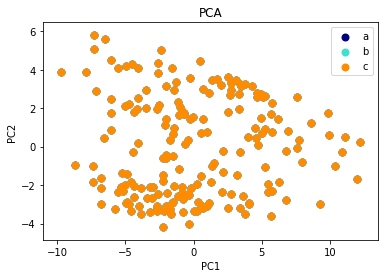

In [73]:
target_names = ['a','b','c']
def plot3clusters(X, title, vtitle):
  plt.figure()
  colors = ['navy', 'turquoise', 'darkorange']
  lw = 2

#   for color, i, target_name in zip(colors, [0, 1, 2], target_names):
#       plt.scatter(X[y == i, 0], X[y == i, 1], color=color, alpha=1., lw=lw,
#                   label=target_name)
  for color, i, target_name in zip(colors, [0, 1, 2], target_names):
      plt.scatter(X[:, 0], X[:, 1], color=color, alpha=1., lw=lw,
                  label=target_name)

  plt.legend(loc='best', shadow=False, scatterpoints=1)
  plt.title(title)  
  plt.xlabel(vtitle + "1")
  plt.ylabel(vtitle + "2")
  plt.show()


pca = decomposition.PCA()
pca_transformed = pca.fit_transform(y_blood_train_norm)
plot3clusters(pca_transformed[:,:2], 'PCA', 'PC')  
plot3clusters(encoded_data[:,:2], 'AE', 'AE')  
